In [1]:
# Production Code

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Solve problem with xgb error

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Production Code

# Pre-checkout sessions include all sessions (sessions reached checkout have events from checkout stripped).
# flag_score = True for Scoring
# For scoring, only keep pre-checkout sessions which do not reach checkout.
# For training, we need all pre-checkout sessions.

flag_score = False
precheckout_file = '20200217_0223_precheckout_sessions.csv'
zone_whl_pickup_orders = '20200223_zone_whl_pickup_orders.csv'
pickup_users = '20200217_0223_pickup_users.csv'

In [4]:
# Production Code

df = pd.read_csv(precheckout_file)
df.rename(columns={i:i.lower() for i in df.columns.tolist()}, 
         inplace=True)
df_BAK = df.copy()

df_zone_whl = pd.read_csv(zone_whl_pickup_orders)
df_zone_whl.rename(columns={i:i.lower() for i in df_zone_whl.columns.tolist()}, 
         inplace=True)

df_users = pd.read_csv(pickup_users)
df_users.rename(columns={i:i.lower() for i in df_users.columns.tolist()}, 
         inplace=True)

In [5]:
df_multiple_sessions = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token']]\
    .groupby(['date', 'zone_id', 'warehouse_location_id', 'user_id'])\
    .count().reset_index()

In [6]:
df_multiple_sessions[df_multiple_sessions['visit_token'] >= 5].head(10)

,date,zone_id,warehouse_location_id,user_id,visit_token
39,2020-02-17,13,21483.0,39855963.0,5
100,2020-02-17,13,36612.0,77009739.0,7
183,2020-02-17,33,9846.0,40602962.0,5
275,2020-02-17,43,627.0,22514975.0,5
299,2020-02-17,43,627.0,44941533.0,10
310,2020-02-17,43,627.0,77617386.0,8
424,2020-02-17,43,639.0,27662508.0,7
435,2020-02-17,43,639.0,42247889.0,6
464,2020-02-17,43,2434.0,36453578.0,5
533,2020-02-17,43,35577.0,30096024.0,5


In [7]:
explore_user_id = 56395472
explore_zone_id = 43

In [8]:
df[(df['date'] == '2020-02-22') & (df['zone_id'] == explore_zone_id) & 
   (df['user_id'] == explore_user_id)]

,date,zone_id,warehouse_location_id,user_id,visit_token,session_start_time,session_end_time,express_ind,order_items_cnt,wait_time_at_session,reached_checkout,num_event_in_session
16618,2020-02-22,43,2434.0,56395472.0,91B33151-8665-423B-96BC-C6B20C5E97EB,2020-02-22 11:46:24.855,2020-02-22 11:53:38.727,0,15.0,67.0,0,4
39439,2020-02-22,43,2434.0,56395472.0,37F1F39E-0BB1-49A6-8770-3208C9258E4F,2020-02-22 13:00:39.664,2020-02-22 13:20:27.041,0,23.0,100.0,1,6
61988,2020-02-22,43,2434.0,56395472.0,B86E7A63-39CB-4656-8B94-5F72D4FD247F,2020-02-22 16:52:01.525,2020-02-22 16:52:01.525,0,0.0,68.0,0,1
69693,2020-02-22,43,2434.0,56395472.0,095725E1-75FB-4943-85A2-2FF0BACAD06D,2020-02-22 08:23:23.953,2020-02-22 08:23:23.953,0,11.0,97.0,0,1
104973,2020-02-22,43,2434.0,56395472.0,D5F89501-2776-493E-9DFC-33ED58632635,2020-02-22 12:24:42.247,2020-02-22 12:24:42.247,0,17.0,96.0,0,1
148267,2020-02-22,43,2434.0,56395472.0,F28BA3A7-96C3-42F0-B288-2A4A3EBAEF34,2020-02-22 10:27:44.563,2020-02-22 10:27:56.020,0,12.0,93.0,0,2
216536,2020-02-22,43,2434.0,56395472.0,E7F98334-38C5-4E71-8230-E2A8C9A42EA1,2020-02-22 16:26:26.678,2020-02-22 16:54:19.704,0,0.0,66.0,0,2
245343,2020-02-22,43,2434.0,56395472.0,6D8017E7-F799-449C-B950-E968FFABB1CA,2020-02-22 13:50:28.281,2020-02-22 13:50:28.281,0,0.0,70.0,0,1


In [9]:
df.columns

Index(['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
       'session_start_time', 'session_end_time', 'express_ind',
       'order_items_cnt', 'wait_time_at_session', 'reached_checkout',
       'num_event_in_session'],
      dtype='object')

In [10]:
# Production Code

df['session_start_time'] = df['session_start_time'].map(lambda x: x[:19])
df['session_start_time'] = pd.to_datetime(df['session_start_time'], format="%Y-%m-%dT%H:%M:%S")

df['session_end_time'] = df['session_end_time'].map(lambda x: x[:19])
df['session_end_time'] = pd.to_datetime(df['session_end_time'], format="%Y-%m-%dT%H:%M:%S")

In [11]:
df.head(3)

,date,zone_id,warehouse_location_id,user_id,visit_token,session_start_time,session_end_time,express_ind,order_items_cnt,wait_time_at_session,reached_checkout,num_event_in_session
0,2020-02-17,988,11775.0,28850571.0,35e5804f-c7a6-411b-b067-c66a0c9da7f9,2020-02-17 09:10:33,2020-02-17 09:10:33,-1,0.0,170.0,0,1
1,2020-02-17,988,11775.0,38321989.0,825CD723-7B32-4693-BD23-6AAD382E931B,2020-02-17 19:49:42,2020-02-17 19:55:07,0,1.0,785.0,0,4
2,2020-02-17,988,11777.0,41679925.0,8DA36966-87DA-4B34-AC3E-F5EF22ED3B12,2020-02-17 12:36:24,2020-02-17 12:38:03,0,1.0,82.0,0,2


In [12]:
if False:
    # Six engineered features is too error prone.
    # So not using it. 
    df['session_time_30min_before'] = df['session_start_time'].map(lambda x: x - timedelta(minutes=30))
    df['session_time_60min_before'] = df['session_start_time'].map(lambda x: x - timedelta(minutes=60))

    df['session_time_30min_after'] = df['session_end_time'].map(lambda x: x + timedelta(minutes=30))
    df['session_time_60min_after'] = df['session_end_time'].map(lambda x: x + timedelta(minutes=60))

    # One session join with every other session
    # Get sessions ended within 30 mins for every session
    df_before_30mins = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time', 'session_time_30min_before']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_before_30mins = df_before_30mins[(df_before_30mins['session_time_30min_before'] 
                                       < df_before_30mins['session_end_time']) & 
                                        (df_before_30mins['session_start_time'] 
                                       > df_before_30mins['session_end_time'])]
    df_before_30mins = df_before_30mins.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_30mins_before', 
                                            'num_event_in_session':'num_event_within_30mins_before'})

    # One session join with every other session
    # Get sessions ended within 60 mins for every session
    df_before_60mins = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time', 'session_time_60min_before']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_before_60mins = df_before_60mins[(df_before_60mins['session_time_60min_before'] 
                                       < df_before_60mins['session_end_time']) & 
                                        (df_before_60mins['session_start_time'] 
                                       > df_before_60mins['session_end_time'])]
    df_before_60mins = df_before_60mins.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_60mins_before', 
                                            'num_event_in_session':'num_event_within_60mins_before'})

    # One session join with every other session
    # Get sessions ended before session started for every session
    df_before = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_before = df_before[df_before['session_start_time'] 
                                       > df_before['session_end_time']]
    df_before = df_before.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_before', 
                                            'num_event_in_session':'num_event_before'})

    # One session join with every other session
    # Get sessions started within 30 mins for every session
    df_after_30mins = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time', 'session_time_30min_after']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_after_30mins = df_after_30mins[(df_after_30mins['session_time_30min_after'] 
                                       > df_after_30mins['session_start_time']) & 
                                        (df_after_30mins['session_end_time'] 
                                       < df_after_30mins['session_start_time'])]
    df_after_30mins = df_after_30mins.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_30mins_after', 
                                            'num_event_in_session':'num_event_within_30mins_after'})

    # One session join with every other session
    # Get sessions started within 60 mins for every session
    df_after_60mins = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time', 'session_time_60min_after']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_after_60mins = df_after_60mins[(df_after_60mins['session_time_60min_after'] 
                                       > df_after_60mins['session_start_time']) & 
                                        (df_after_60mins['session_end_time'] 
                                       < df_after_60mins['session_start_time'])]
    df_after_60mins = df_after_60mins.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_60mins_after', 
                                            'num_event_in_session':'num_event_within_60mins_after'})

    # One session join with every other session
    # Get sessions started after session ended for every session
    df_after = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_end_time']]\
        .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
        'session_start_time', 'reached_checkout', 'num_event_in_session']]\
        .rename(columns={'visit_token':'visit_token_joined'}),
        on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
        how='left')
    df_after = df_after[df_after['session_start_time'] 
                                       > df_after['session_end_time']]
    df_after = df_after.groupby(['date', 'zone_id', 'warehouse_location_id', 
                    'user_id', 'session_start_time', 'visit_token'])\
        .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_after', 
                                            'num_event_in_session':'num_event_after'})

In [13]:
# Production Code

# One session join with every other session
# Get sessions ended before session started for every session
df_before = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
    'session_start_time']]\
    .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
    'session_end_time', 'reached_checkout', 'num_event_in_session']]\
    .rename(columns={'visit_token':'visit_token_joined',
                    'session_end_time':'session_end_time_joined'}),
    on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
    how='left')
df_before = df_before[df_before['session_end_time_joined'] 
                                   < df_before['session_start_time']]
df_before = df_before.groupby(['date', 'zone_id', 'warehouse_location_id', 
                'session_start_time', 'user_id', 'visit_token'])\
    .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_before', 
                                        'num_event_in_session':'num_event_before'})

# One session join with every other session
# Get sessions started after session ended for every session
df_after = df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
    'session_end_time']]\
    .merge(df[['date', 'zone_id', 'warehouse_location_id', 'user_id', 'visit_token',
    'session_start_time', 'reached_checkout', 'num_event_in_session']]\
    .rename(columns={'visit_token':'visit_token_joined',
                    'session_start_time':'session_start_time_joined'}),
    on=['date', 'zone_id', 'warehouse_location_id', 'user_id'],
    how='left')
df_after = df_after[df_after['session_start_time_joined'] 
                                   > df_after['session_end_time']]
df_after = df_after.groupby(['date', 'zone_id', 'warehouse_location_id', 
                'user_id', 'session_end_time', 'visit_token'])\
    .sum().reset_index().rename(columns={'reached_checkout':'reached_checkout_after', 
                                        'num_event_in_session':'num_event_after'})

# Join df_before and df_after
df = df.merge(df_before[['date', 'zone_id', 'warehouse_location_id', 
                        'user_id', 'visit_token', 'reached_checkout_before',
                       'num_event_before']],
            on=['date', 'zone_id', 'warehouse_location_id', 
                        'user_id', 'visit_token'],
            how='left')
df = df.merge(df_after[['date', 'zone_id', 'warehouse_location_id', 
                        'user_id', 'visit_token', 'reached_checkout_after',
                       'num_event_after']],
            on=['date', 'zone_id', 'warehouse_location_id', 
                        'user_id', 'visit_token'],
            how='left')

# Fill in NA num_event_after and num_event_before
df.fillna(value={'reached_checkout_before':0,
                'num_event_before':0,
                'reached_checkout_after':0,
                'num_event_after':0}, inplace=True)

if flag_score == True:
    df = df[df['reached_checkout'] == 0].copy()

In [14]:
df[df['user_id'] == explore_user_id].sort_values(by=['session_start_time'])

,date,zone_id,warehouse_location_id,user_id,visit_token,session_start_time,session_end_time,express_ind,order_items_cnt,wait_time_at_session,reached_checkout,num_event_in_session,reached_checkout_before,num_event_before,reached_checkout_after,num_event_after
199621,2020-02-19,43,2434.0,56395472.0,1B35D2EB-50F1-41B0-AB3E-FA712C5249EA,2020-02-19 19:24:43,2020-02-19 19:24:43,0,0.0,816.0,0,1,0.0,0.0,0.0,0.0
60938,2020-02-20,43,2434.0,56395472.0,3CCDB21D-9C66-4501-B243-1A2FC1D340E6,2020-02-20 18:41:56,2020-02-20 18:42:54,0,3.0,78.0,0,3,0.0,0.0,0.0,0.0
263234,2020-02-21,43,2434.0,56395472.0,237D6E19-45E0-434E-8183-DB87A083EC3A,2020-02-21 21:40:54,2020-02-21 22:01:49,0,12.0,659.0,0,5,0.0,0.0,0.0,1.0
178002,2020-02-21,43,2434.0,56395472.0,78BDF0CE-CB6D-41E3-A133-8E54CDF19879,2020-02-21 22:51:03,2020-02-21 22:51:03,0,10.0,609.0,0,1,0.0,5.0,0.0,0.0
69693,2020-02-22,43,2434.0,56395472.0,095725E1-75FB-4943-85A2-2FF0BACAD06D,2020-02-22 08:23:23,2020-02-22 08:23:23,0,11.0,97.0,0,1,0.0,0.0,1.0,17.0
148267,2020-02-22,43,2434.0,56395472.0,F28BA3A7-96C3-42F0-B288-2A4A3EBAEF34,2020-02-22 10:27:44,2020-02-22 10:27:56,0,12.0,93.0,0,2,0.0,1.0,1.0,15.0
16618,2020-02-22,43,2434.0,56395472.0,91B33151-8665-423B-96BC-C6B20C5E97EB,2020-02-22 11:46:24,2020-02-22 11:53:38,0,15.0,67.0,0,4,0.0,3.0,1.0,11.0
104973,2020-02-22,43,2434.0,56395472.0,D5F89501-2776-493E-9DFC-33ED58632635,2020-02-22 12:24:42,2020-02-22 12:24:42,0,17.0,96.0,0,1,0.0,7.0,1.0,10.0
39439,2020-02-22,43,2434.0,56395472.0,37F1F39E-0BB1-49A6-8770-3208C9258E4F,2020-02-22 13:00:39,2020-02-22 13:20:27,0,23.0,100.0,1,6,0.0,8.0,0.0,4.0
245343,2020-02-22,43,2434.0,56395472.0,6D8017E7-F799-449C-B950-E968FFABB1CA,2020-02-22 13:50:28,2020-02-22 13:50:28,0,0.0,70.0,0,1,1.0,14.0,0.0,3.0


In [15]:
# Production Code
# Feature engineerings

# Express
df['is_express'] = df['express_ind'].map(lambda x: 1 if x == 1 else 0)
df['is_unknown'] = df['express_ind'].map(lambda x: 1 if x == -1 else 0)

# Checkout Before And After
df['did_checkout_before'] = df['reached_checkout_before'].map(lambda x: 1 if x >= 1 else 0)
df['did_checkout_after'] = df['reached_checkout_after'].map(lambda x: 1 if x >= 1 else 0)

# Get session length
df['session_length'] = (df['session_end_time'] - df['session_start_time']).map(lambda x: x.seconds / 60)
df['session_length_tier'] = df['session_length'].map(lambda x: 0 if x < 1 else
                                                               1 if x < 2 else
                                                               2 if x < 5 else
                                                               3 if x < 10 else
                                                               4 if x < 20 else
                                                               5 if x < 50 else
                                                               6 if x < 100 else
                                                               7 if x < 200 else
                                                               8)

# Get num_event_in_session feature
df['num_event_in_session_tier'] = df['num_event_in_session'].map(lambda x: 0 if x <= 1 else
                                                               1 if x <= 2 else
                                                               2 if x <= 5 else
                                                               3 if x <= 10 else
                                                               4 if x <= 20 else
                                                               5)

df['num_event_before_tier'] = df['num_event_before'].map(lambda x: 0 if x <= 1 else
                                                               1 if x <= 2 else
                                                               2 if x <= 5 else
                                                               3 if x <= 10 else
                                                               4 if x <= 20 else
                                                               5 if x <= 50 else
                                                               6)

df['num_event_after_tier'] = df['num_event_after'].map(lambda x: 0 if x <= 1 else
                                                               1 if x <= 2 else
                                                               2 if x <= 5 else
                                                               3 if x <= 10 else
                                                               4 if x <= 20 else
                                                               5 if x <= 50 else
                                                               6)

df.fillna(value={'order_items_cnt':0}, inplace=True)
df['order_items_cnt_tier'] = df['order_items_cnt'].map(lambda x: 0 if x <= 1 else
                                                               1 if x <= 2 else
                                                               2 if x <= 5 else
                                                               3 if x <= 10 else
                                                               4 if x <= 20 else
                                                               5)

# DOW
df['dow'] = df['session_start_time'].map(lambda x: x.weekday())
df['is_sunday'] = df['dow'].map(lambda x: 1 if x == 6 else 0)
df['is_saturday'] = df['dow'].map(lambda x: 1 if x == 5 else 0)
df['is_monday'] = df['dow'].map(lambda x: 1 if x == 0 else 0)

# Hour
df['hour'] = df['session_start_time'].map(lambda x: x.hour)
df['2hr_eligible'] = df['hour'].map(lambda x: 1 if x >= 7 and x <= 18 else 0)
df['morning'] = df['hour'].map(lambda x: 1 if x >= 7 and x <= 11 else 0)
df['peak_hour'] = df['hour'].map(lambda x: 1 if x >= 12 and x <= 15 else 0)
df['evening'] = df['hour'].map(lambda x: 1 if x >= 16 and x <= 18 else 0)


# 2hr available
df['avail_2hr'] = df['wait_time_at_session'].map(lambda x: 1 if x <= 120.0 else 0)

# Get features about zone/whl pickup orders
# Join with df_zone_whl
df = df.merge(df_zone_whl,
             on=['zone_id', 'warehouse_location_id'],
             how='left')

# Fill in records with whl_id is null.
df = df.merge(df_zone_whl[['zone_id', 'zone_pickup_orders']].drop_duplicates()\
              .rename(columns={'zone_pickup_orders':'zone_pickup_orders_to_fillna'}),
             on=['zone_id'],
             how='left')

# Fill in zone_pickup_orders for those whls do not have pickup orders. 
df.loc[df['zone_pickup_orders'].isnull(), 'zone_pickup_orders'] = df['zone_pickup_orders_to_fillna']
# If zone_pickup_orders is still NA here, means the zone does not have pickup orders yet. 
df.fillna(value={'zone_pickup_orders':0}, inplace=True)

# Fill in NA whl_pickup_orders
df_zone_whl_orders_median = df_zone_whl[['zone_id', 'whl_pickup_orders']]\
        .groupby(['zone_id']).median().reset_index()
df = df.merge(df_zone_whl_orders_median[['zone_id', 'whl_pickup_orders']]\
              .rename(columns={'whl_pickup_orders':'whl_pickup_orders_to_fillna'}),
             on=['zone_id'],
             how='left')
df.loc[df['whl_pickup_orders'].isnull(), 'whl_pickup_orders'] = df['whl_pickup_orders_to_fillna']
# If whl_pickup_orders is still NA here, means the whl does not have pickup orders yet. 
df.fillna(value={'whl_pickup_orders':0}, inplace=True)

df['zone_pickup_orders_tier'] = df['zone_pickup_orders'].map(lambda x: 0 if x <= 100 else
                                                               1 if x <= 200 else
                                                               2 if x <= 500 else
                                                               3 if x <= 1000 else
                                                               4 if x <= 2000 else
                                                               5)

df['whl_pickup_orders_tier'] = df['whl_pickup_orders'].map(lambda x: 0 if x <= 20 else
                                                               1 if x <= 50 else
                                                               2 if x <= 100 else
                                                               3 if x <= 200 else
                                                               4)

# Join with Users
df = df.merge(df_users[['user_id', 'sign_in_count', 'orders_count', 'days']],
             on=['user_id'],
             how='left')
df.fillna(value={'sign_in_count':0, 'orders_count':0, 'days':0}, inplace=True)
df['sign_in_count_tier'] = df['sign_in_count'].map(lambda x: 0 if x <= 2 else
                                                               1 if x <= 5 else
                                                               2 if x <= 10 else
                                                               3 if x <= 20 else
                                                               4 if x <= 50 else
                                                               5 if x <= 100 else
                                                               6)
df['orders_count_tier'] = df['orders_count'].map(lambda x: 0 if x <= 2 else
                                                               1 if x <= 5 else
                                                               2 if x <= 10 else
                                                               3 if x <= 20 else
                                                               4 if x <= 50 else
                                                               5 if x <= 100 else
                                                               6)
df['days_tier'] = df['days'].map(lambda x: 0 if x <= 7 else
                                           1 if x <= 28 else
                                           2 if x <= 60 else
                                           3 if x <= 180 else
                                           4 if x <= 360 else
                                           5 if x <= 720 else
                                           6)

In [16]:
df.isnull().sum()

date                               0
zone_id                            0
warehouse_location_id           4575
user_id                          192
visit_token                        0
session_start_time                 0
session_end_time                   0
express_ind                        0
order_items_cnt                    0
wait_time_at_session              30
reached_checkout                   0
num_event_in_session               0
reached_checkout_before            0
num_event_before                   0
reached_checkout_after             0
num_event_after                    0
is_express                         0
is_unknown                         0
did_checkout_before                0
did_checkout_after                 0
session_length                     0
session_length_tier                0
num_event_in_session_tier          0
num_event_before_tier              0
num_event_after_tier               0
order_items_cnt_tier               0
dow                                0
i

### Explore signal of reaching checkout

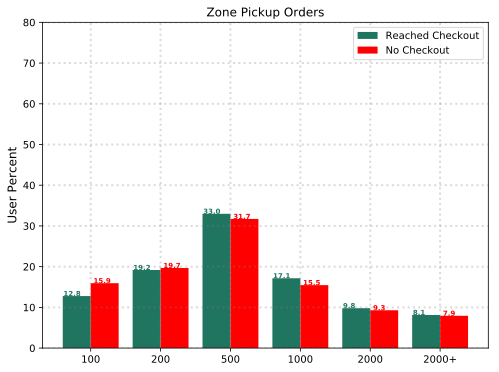

In [17]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'zone_pickup_orders_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Zone Pickup Orders')
ax1.set_xticks(x)
ax1.set_xticklabels(('100', '200', '500','1000', '2000', '2000+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

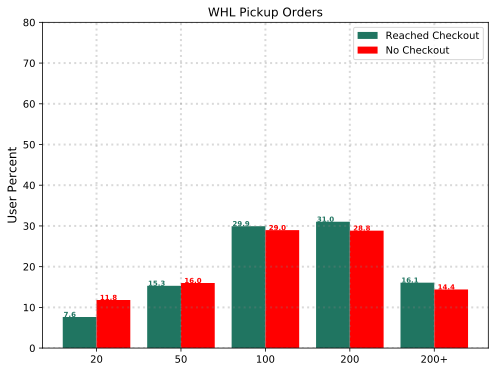

In [18]:
x = [i for i in range(5)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'whl_pickup_orders_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('WHL Pickup Orders')
ax1.set_xticks(x)
ax1.set_xticklabels(('20', '50','100', '200', '200+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

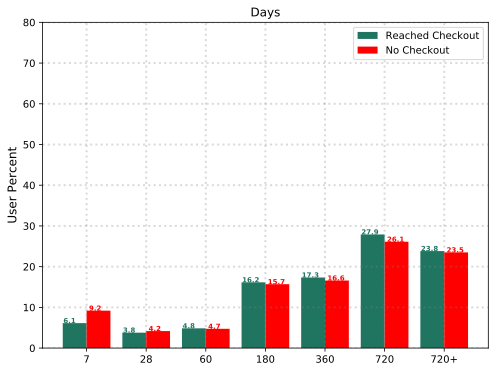

In [19]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'days_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Days')
ax1.set_xticks(x)
ax1.set_xticklabels(('7', '28','60', '180', '360', '720', '720+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

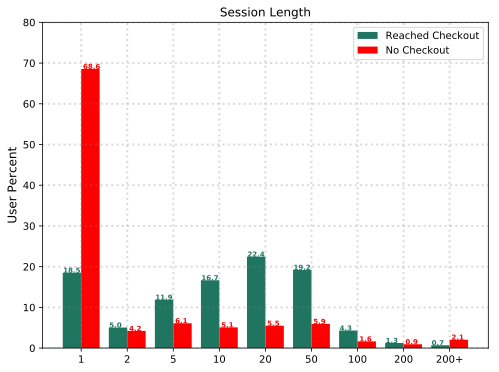

In [20]:
x = [i for i in range(9)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'session_length_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Session Length')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '100', '200', '200+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

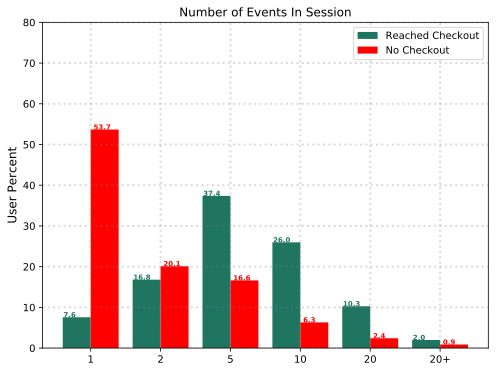

In [21]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_in_session_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number of Events In Session')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '20+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

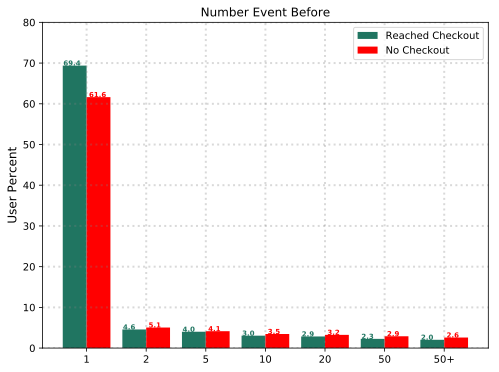

In [22]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_before'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number Event Before')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '50+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

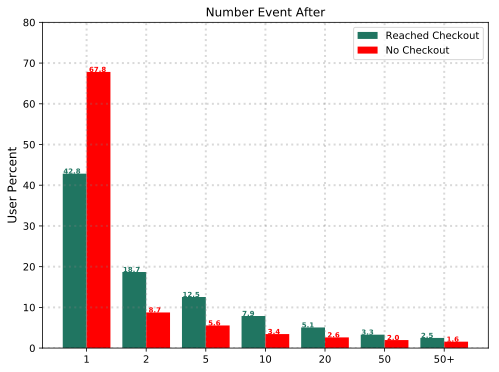

In [23]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'num_event_after'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Number Event After')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '50', '50+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

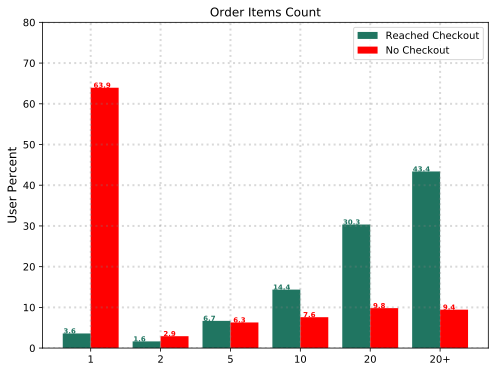

In [24]:
x = [i for i in range(6)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'order_items_cnt_tier'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Order Items Count')
ax1.set_xticks(x)
ax1.set_xticklabels(('1', '2', '5','10', '20', '20+'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

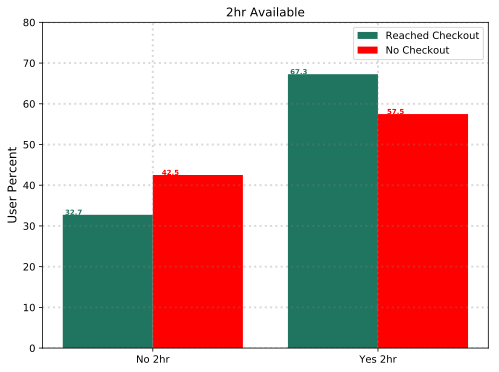

In [25]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'avail_2hr'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('2hr Available')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 2hr', 'Yes 2hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

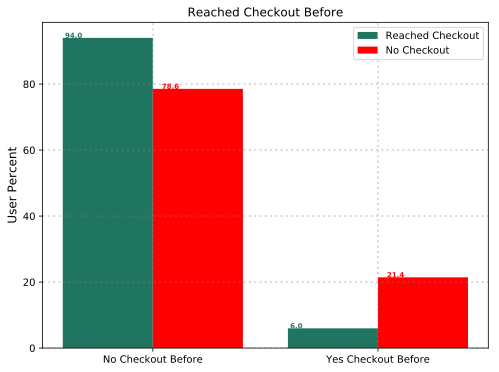

In [26]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'did_checkout_before'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Reached Checkout Before')
ax1.set_xticks(x)
ax1.set_xticklabels(('No Checkout Before', 'Yes Checkout Before'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

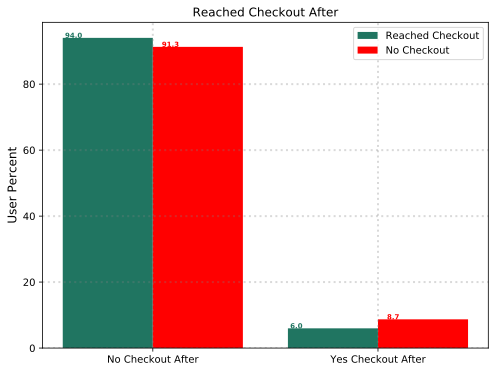

In [27]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'did_checkout_after'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Reached Checkout After')
ax1.set_xticks(x)
ax1.set_xticklabels(('No Checkout After', 'Yes Checkout After'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

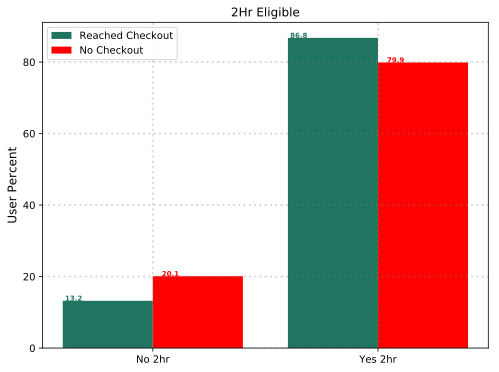

In [28]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = '2hr_eligible'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('2Hr Eligible')
ax1.set_xticks(x)
ax1.set_xticklabels(('No 2hr', 'Yes 2hr'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

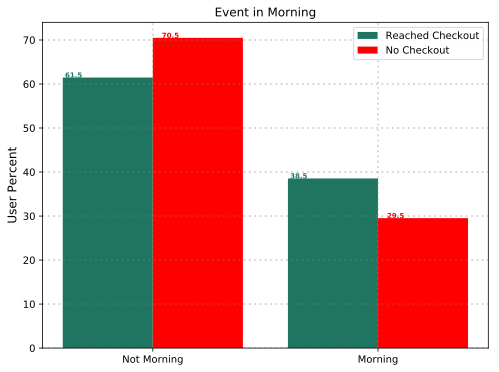

In [29]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'morning'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Event in Morning')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Morning', 'Morning'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

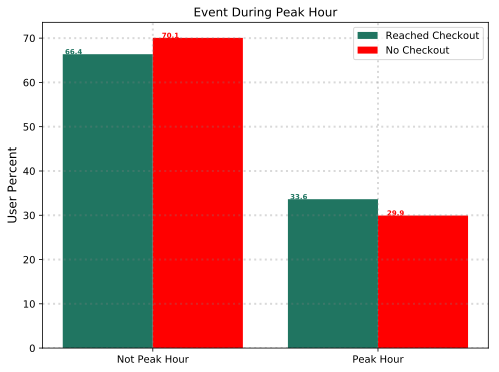

In [30]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'peak_hour'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Event During Peak Hour')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Peak Hour', 'Peak Hour'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

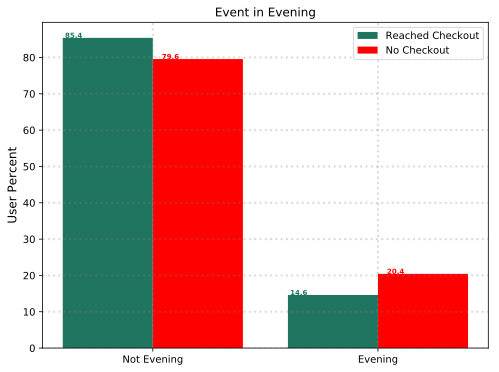

In [31]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'evening'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Event in Evening')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Evening', 'Evening'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

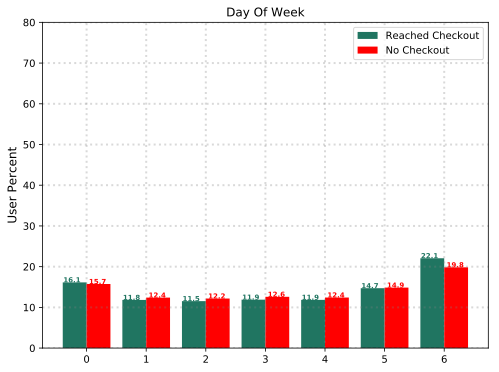

In [32]:
x = [i for i in range(7)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'dow'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Day Of Week')
ax1.set_xticks(x)
ax1.set_xticklabels(('0', '1', '2','3', '4', '5', '6'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.set_ylim([0, 80])
ax1.legend(loc='best')
plt.show()

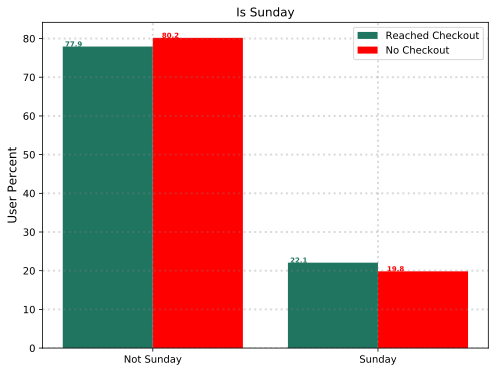

In [33]:
x = [i for i in range(2)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'is_sunday'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Is Sunday')
ax1.set_xticks(x)
ax1.set_xticklabels(('Not Sunday', 'Sunday'))
for i, v in enumerate(y1):
    ax1.text(i - 0.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i + 0.04, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

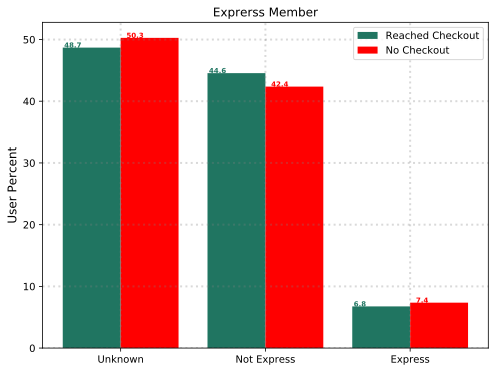

In [34]:
x = [i - 1 for i in range(3)]
x1 = [i - 0.2 for i in x]
x2 = [i + 0.2 for i in x]
feature = 'express_ind'
ind_width = 0.4

df_reach_checkout = df[df['reached_checkout'] == 1][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})

df_not_checkout = df[df['reached_checkout'] == 0][[feature, 'user_id']]\
    .groupby(feature).count().reset_index()\
    .rename(columns={'user_id':'user_count'})
tot_user1 = sum(df_reach_checkout['user_count'])
df_reach_checkout.set_index(feature, inplace=True)
df_reach_checkout = df_reach_checkout.reindex(x, fill_value=0)
y1 = [i * 100 / float(tot_user1) for i in df_reach_checkout['user_count'].tolist()]

tot_user2 = sum(df_not_checkout['user_count'])
df_not_checkout.set_index(feature, inplace=True)
df_not_checkout = df_not_checkout.reindex(x, fill_value=0)
y2 = [i * 100 / float(tot_user2) for i in df_not_checkout['user_count'].tolist()]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#207561', width=ind_width, label='Reached Checkout')
ax1.bar(x2, y2, align='center', color='#ff0000', width=ind_width, label='No Checkout')
ax1.set_ylabel('User Percent',fontsize=12)
ax1.set_title('Exprerss Member')
ax1.set_xticks(x)
ax1.set_xticklabels(('Unknown', 'Not Express', 'Express'))
for i, v in enumerate(y1):
    ax1.text(i - 1.39, v, str(round(v, 1)), color='#207561', fontweight='bold', fontsize=7)
for i, v in enumerate(y2):
    ax1.text(i - 0.96, v, str(round(v, 1)), color='#ff0000', fontweight='bold', fontsize=7)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax1.legend(loc='best')
plt.show()

In [35]:
# Production Code
# Training and testing
# is_monday, is_saturday are not important 

features = ['session_length_tier', 'num_event_in_session_tier', 'avail_2hr',
           'did_checkout_before', 'did_checkout_after', 'num_event_before_tier',
           'num_event_after_tier', 'order_items_cnt_tier', '2hr_eligible',
           'morning', 'peak_hour', 'evening', 'is_sunday', 'is_saturday',
            'is_monday', 'is_express', 'is_unknown', 'zone_pickup_orders_tier',
           'whl_pickup_orders_tier', 'sign_in_count_tier', 'orders_count_tier',
           'days_tier']
data = df[features + ['reached_checkout']].copy()

train_data, test_data = train_test_split(data, test_size=0.2)
train_data, train_label = train_data[features], train_data['reached_checkout']
test_data, test_label = test_data[features], test_data['reached_checkout']

In [36]:
data.isnull().sum()

session_length_tier          0
num_event_in_session_tier    0
avail_2hr                    0
did_checkout_before          0
did_checkout_after           0
num_event_before_tier        0
num_event_after_tier         0
order_items_cnt_tier         0
2hr_eligible                 0
morning                      0
peak_hour                    0
evening                      0
is_sunday                    0
is_saturday                  0
is_monday                    0
is_express                   0
is_unknown                   0
zone_pickup_orders_tier      0
whl_pickup_orders_tier       0
sign_in_count_tier           0
orders_count_tier            0
days_tier                    0
reached_checkout             0
dtype: int64

In [37]:
# Production Code
# Define model parameters and hyperparamter tuning

flag_model = 'xgb'
flag_search = 'random'

# scoring="neg_log_loss", 'f1', 'roc_auc'
xgb = XGBClassifier(n_jobs=-1, silent=1, subsample=0.9, objective='binary:logistic',
                   scoring='roc_auc')    
rf = RandomForestClassifier(n_jobs=-1)

if flag_model == 'xgb': 
    model = xgb
    params_grid = {
        "max_depth" : [3, 4, 5, 6, 7],
        "n_estimators": [20, 40, 60, 80, 100, 120, 140],
        "min_child_weight": [1, 3, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
    params_random = {
        "max_depth" : [2, 3, 4, 5, 6, 7, 8],
        "n_estimators": [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
        "min_child_weight": [1, 2, 3, 4, 5],
        "gamma": [i/10.0 for i in range(3,6)]
         }
else:
    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae' or 'mse'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae' or 'mse'
     }
    
if flag_search == 'grid':
    grid = GridSearchCV(estimator=model, param_grid=params_grid, cv=8)
else:
    grid = RandomizedSearchCV(estimator=model, param_distributions=params_random, cv=8)

grid.fit(train_data, train_label)

print(grid.best_params_)
print('Best scores: %.3f'%(grid.best_score_))

{'n_estimators': 140, 'min_child_weight': 4, 'max_depth': 8, 'gamma': 0.3}
Best scores: 0.884


In [38]:
# Production
# Model validation

ypred = grid.best_estimator_.predict(test_data)
ypred_proba = grid.best_estimator_.predict_proba(test_data)
df_pred = pd.DataFrame(test_label)
df_pred = df_pred.assign(pred=list(ypred))
df_pred = df_pred.assign(pred_proba=list(ypred_proba))
df_pred['pred_proba'] = df_pred['pred_proba'].map(lambda x: x[1])

In [39]:
# Production 
# For lost demand

ideal_data = test_data.copy()
ideal_data.loc[(ideal_data['avail_2hr'] == 0) & (ideal_data['2hr_eligible'] == 1), 'avail_2hr'] = 1
ypred_ideal = grid.best_estimator_.predict_proba(ideal_data)
df_pred = df_pred.assign(pred_proba_ideal=list(ypred_ideal))
df_pred['pred_proba_ideal'] = df_pred['pred_proba_ideal'].map(lambda x: x[1])
df_pred['ld'] = df_pred['pred_proba_ideal'] - df_pred['pred_proba']

In [40]:
len(df_pred[df_pred['ld'] > 0])

9558

In [41]:
len(df_pred[df_pred['ld'] < 0])

5432

In [42]:
# Production

from sklearn.metrics import f1_score, roc_auc_score, log_loss

f1 = f1_score(df_pred.reached_checkout, df_pred.pred)
print('f1: %.3f.'%(f1))
f1_micro = f1_score(df_pred.reached_checkout, df_pred.pred, average='micro')
print('f1 micro: %.3f.'%(f1_micro))
f1_macro = f1_score(df_pred.reached_checkout, df_pred.pred, average='macro')
print('f1 macro: %.3f.'%(f1_macro))
roc_auc = roc_auc_score(df_pred.reached_checkout, df_pred.pred)
print('ROC AUC: %.3f.'%(roc_auc))
log_loss = log_loss(df_pred.reached_checkout, df_pred.pred_proba)
print('Log Loss: %.3f.'%(log_loss))

df_pred.head(3)

f1: 0.680.
f1 micro: 0.884.
f1 macro: 0.805.
ROC AUC: 0.793.
Log Loss: 0.259.


,reached_checkout,pred,pred_proba,pred_proba_ideal,ld
180283,0,0,0.036312,0.036312,0.0
247471,0,0,0.122118,0.122118,0.0
159807,1,1,0.796686,0.796686,0.0


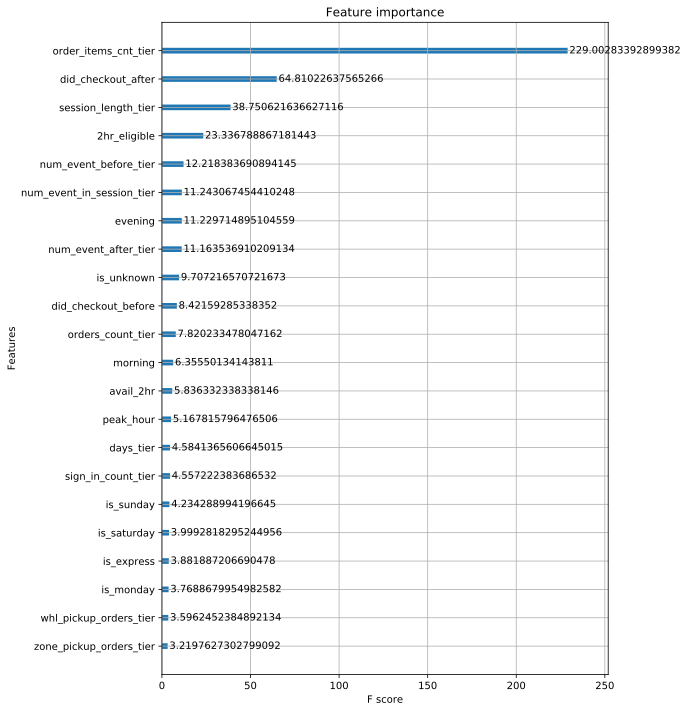

In [43]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='gain')
plt.show()

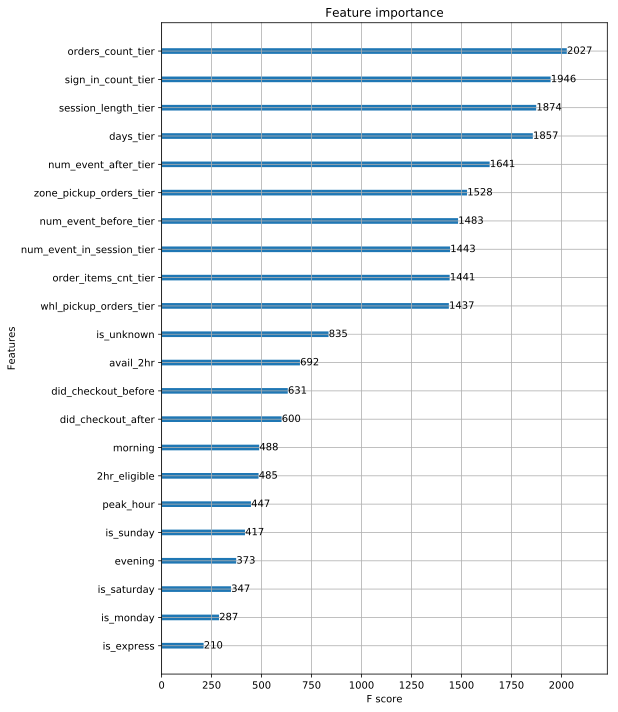

In [44]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax)
plt.show()

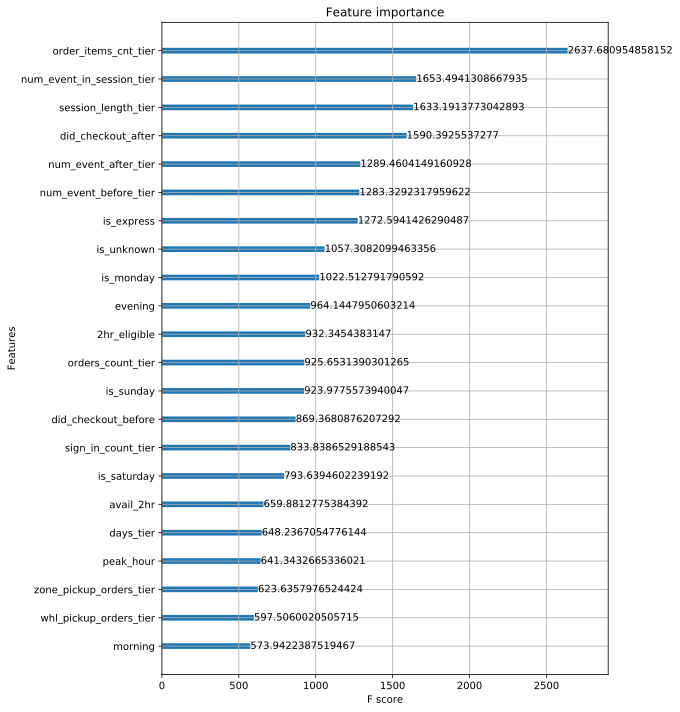

In [45]:
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(111)
plot_importance(grid.best_estimator_, ax=ax, importance_type='cover')
plt.show()